In [47]:
import networkx as nx
import networkx.algorithms.bipartite as bipartite
import matplotlib.pyplot as plt
# %matplotlib notebook
import pandas as pd
import json

In [43]:
def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])

In [93]:
def show_graph(graph):
    #initialze Figure
    plt.figure(num=None, figsize=(20, 20), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    nx.draw_networkx_labels(graph,pos)

    cut = 1.00
    plt.show()

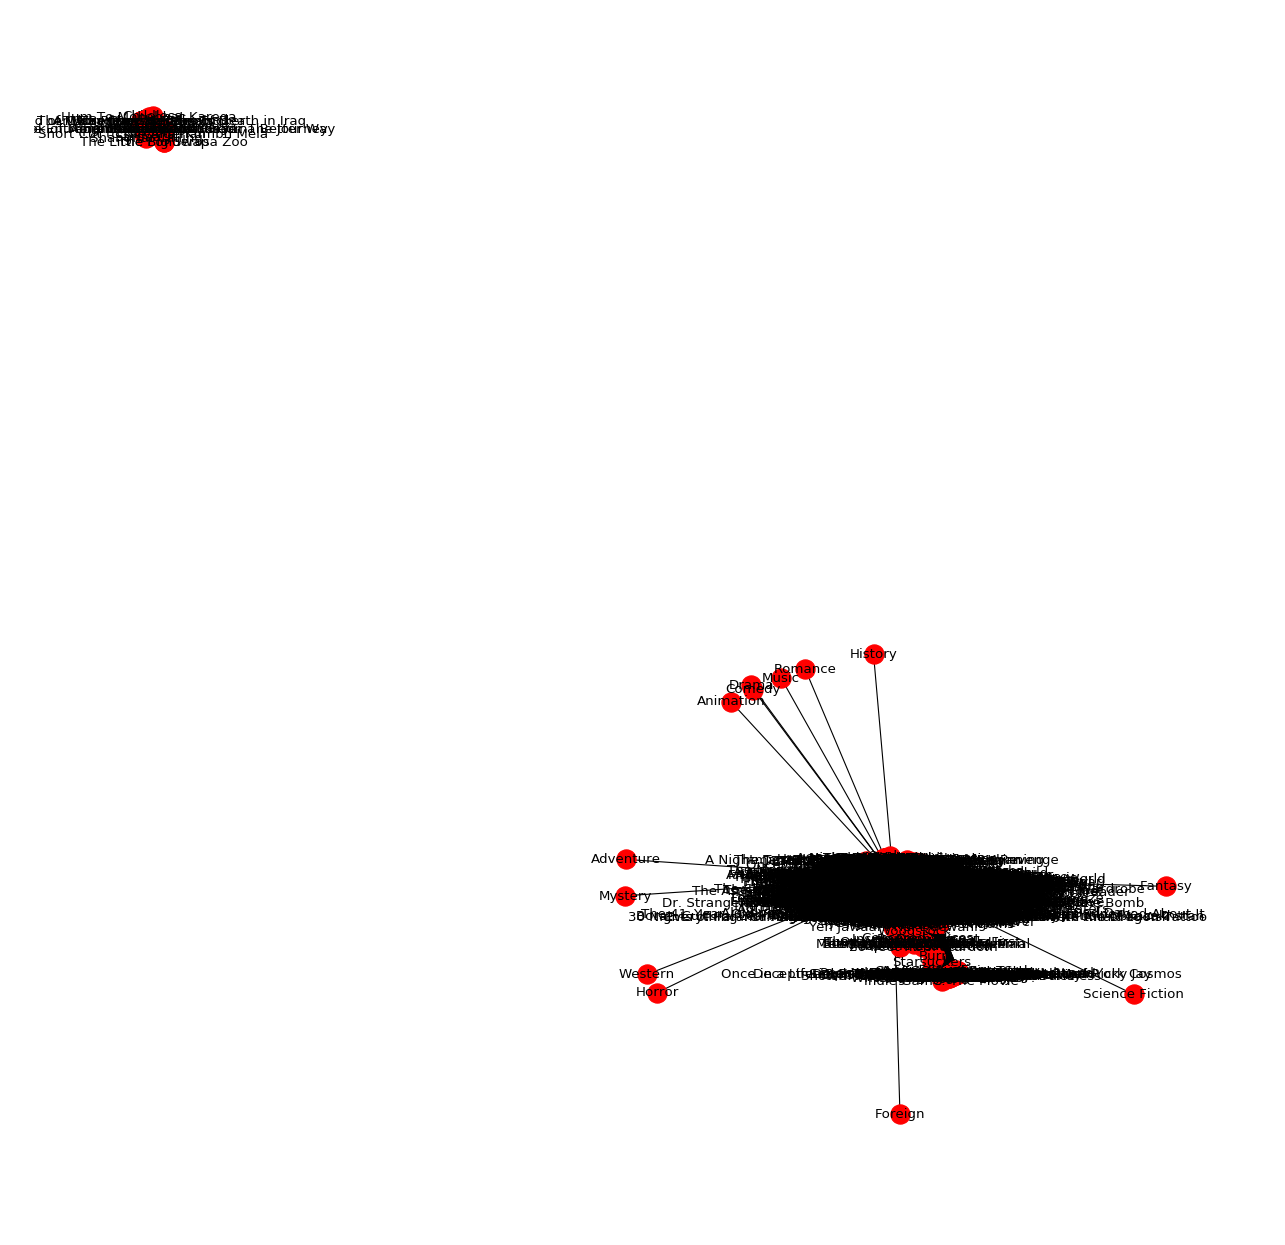

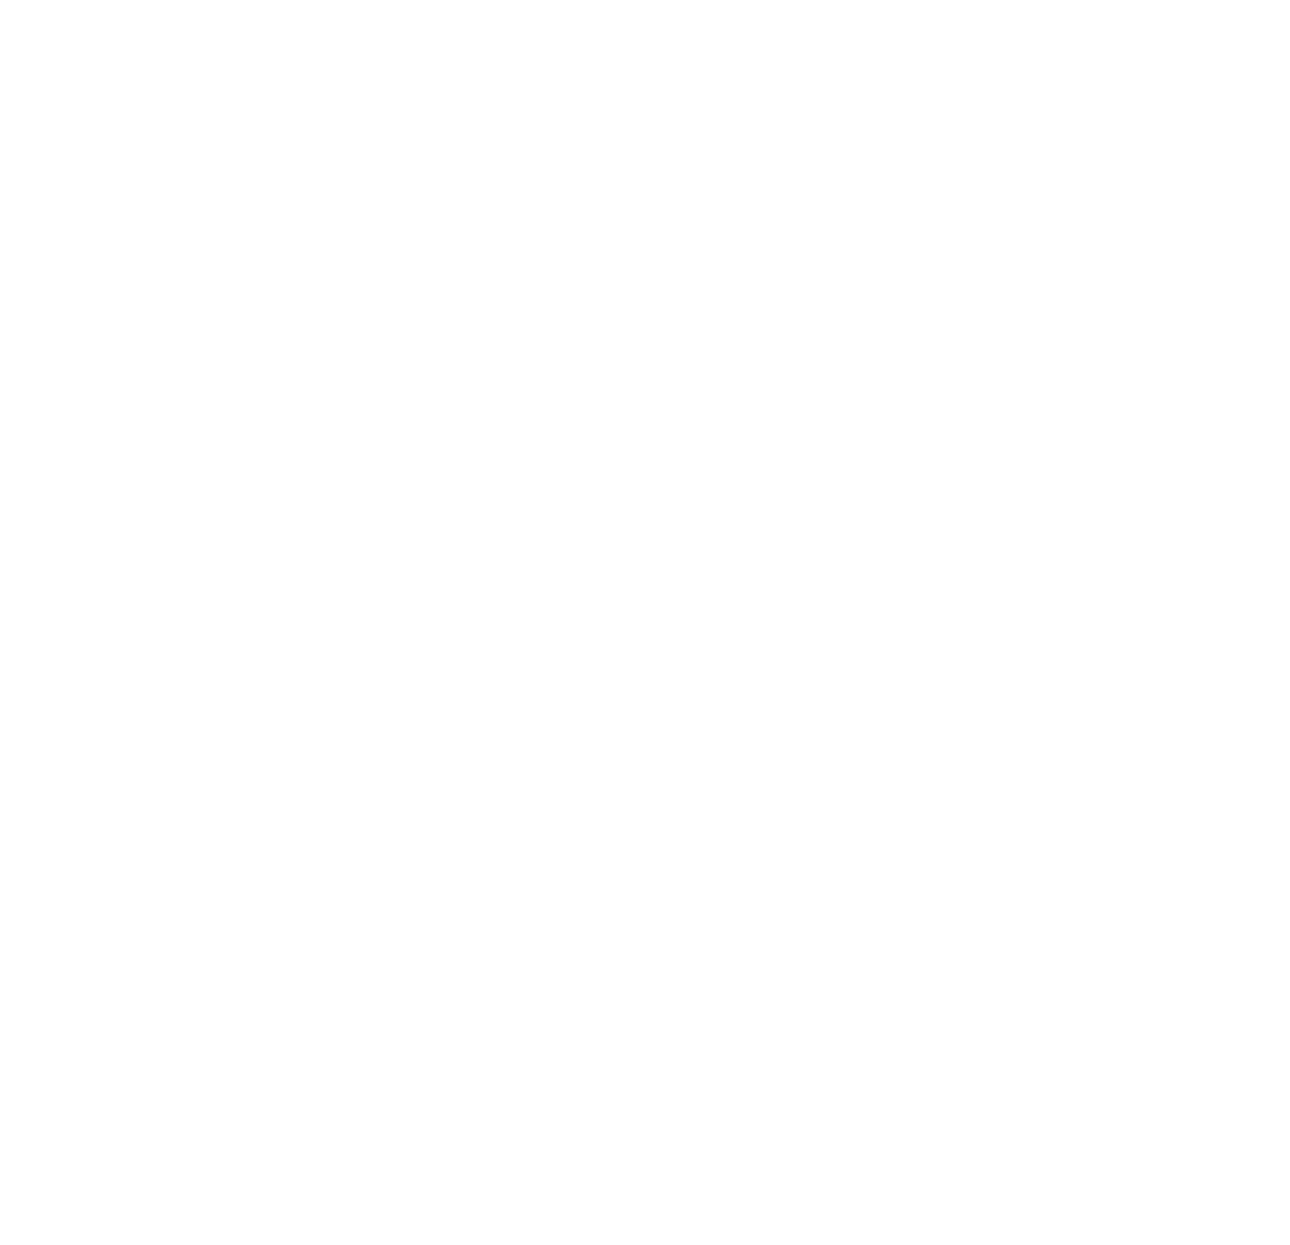

In [94]:
show_graph(W)

In [ ]:
def draw_chart(G):

    """This function plots the chart according to the graph type. 
    If it is bipartite graph type, it shows the circular graph.
    
    If not it will show the random networkx graph."""
    if nx.is_bipartite(G):
        edge_width = [1 for u,v in G.edges()]
        node_color =[5 if G.node[g]['bipartite'] ==0 else 8 for g in G.nodes()]
        node_size = [G.degree(v)*100 for v in G]
        pos = nx.circular_layout(G)

    else:
        node_color = [G.degree(v)*100 for v in G]
        node_size = [G.degree(v)*100 for v in G]
        if nx.is_weighted(G):
            edge_width = [0.5*G[u][v]['weight'] for u,v in G.edges()]
        else:
            edge_width = [1 for u,v in G.edges()]
        pos = nx.random_layout(G)
        
    plt.figure(figsize=(7,7))
    nx.draw_networkx(G, pos,node_color=node_color,alpha=0.5,with_labels=True, 
                    width=edge_width, edge_color ='.4',node_size=node_size)
    plt.show()

In [102]:
def trim_edges (g, variable, weight=1):
    g2= nx.Graph()
    
    for f, to, edata in g.edges(data=True):
        if edata[variable] > weight:
            g2.add_edge(f,to,edata)
    return g2

In [103]:
def island_method(g, variable, iterations=5):
    """Using island method, we are limiting the number of nodes and clusters. 
    It calls trim edges with a threshold value. 
    
    Output of this function is the list of graphs with different threshold level.
    """
    weights= [edata[variable] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    print(mx)
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)
    return [[threshold, trim_edges(g,variable, threshold)] for threshold in range(mn,mx,step)]

In [104]:
def sorted_map(map1):
    """Defined a function to sort the dictionary"""
    ms = sorted(map1.items(), key =lambda k: -k[1])
    return ms

In [105]:
def node_info(G):
    """Provides various information of that particular graph. It calculates the
    diameter, radius and other information"""
    
    print("\nNode information:{}".format(nx.info(G)))    
    #print("\nGraph Diameter:{}".format(nx.diameter(G)))
    #print("\nGraph Radius:{}".format(nx.radius(G)))

In [99]:
def helping_function(G, variable, method="Y"):
    """Helping function to call all the other functions."""
    
    if nx.is_bipartite(G):
        node_info(G)
        #triange_edges(G)
#        draw_chart(G)
    else:
        node_info(G)
        #triange_edges(G)
        if(method =="Y"):
            result_island = island_method(G,variable)[3][1]
            #nodes_analysis(result_island)
            #draw_chart(result_island)
        elif(method=="N"):
            nodes_analysis(G)
            #draw_chart(G)
    return(result_island)

In [108]:
if __name__ == "__main__":
    
    df = pd.read_csv('./data/tmdb_5000_movies.csv',sep=',')[['genres','homepage','title','vote_average','popularity','budget','vote_count','original_language']]

    df['genres'] = df['genres'].apply(json.loads)
    df['genres']  = df['genres'].apply(pipe_flatten_names)

    g = nx.Graph()

    movie_list =[]
    genre_list = []

    for index,data in df.iterrows():
        #Movie
        g.add_node(data[2],bipartite="Actor")
        movie_list.append(data[2])
        #Genre
        for genre in data[0].split('|'):
            genre_list.append(genre)
            g.add_node(genre,bipartite="Genre")
            g.add_edge(data[2],genre,vote_average =data[3],popularity=data[4], \
                  budget=data[5],vote_count=data[6])
        
    
    island_budget = helping_function(g,'budget')
    island_popularity = helping_function(g,'popularity')
    island_vote_avg= helping_function(g,'vote_average')
    island_vote_cnt = helping_function(g,'vote_count')
    
    #W = bipartite.projected_graph(g, movie_list)


Node information:Name: 
Type: Graph
Number of nodes: 4820
Number of edges: 12186
Average degree:   5.0564
380000000

Node information:Name: 
Type: Graph
Number of nodes: 4820
Number of edges: 12186
Average degree:   5.0564
875

Node information:Name: 
Type: Graph
Number of nodes: 4820
Number of edges: 12186
Average degree:   5.0564
10

Node information:Name: 
Type: Graph
Number of nodes: 4820
Number of edges: 12186
Average degree:   5.0564
13752
